In [39]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [40]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# 1. Load & Preprocess Data

In [166]:
# 3:color or 1:grayscale
depth = 4
image_size_y = 64
image_size_x = 64

image_data = []

for image in glob.glob('test_dataset/*.jpg'):
    img = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    
    # https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_matplotlib_rgb_brg_image_load_display_save.php
    b,g,r,a = cv2.split(img)       # get b,g,r,a
    img = cv2.merge([r,g,b,a])     # switch it to rgba

    img = cv2.resize(img, dsize=(image_size_y, image_size_x), interpolation=cv2.INTER_AREA)
    image_data.append(img)
        
image_data = np.array(image_data, dtype='float32')

image_plotting = image_data / 255.0

train_image = image_data.reshape(len(image_data), image_size_x, image_size_y, depth)

train_dataset = (image_data - 127.5) / 127.5 

train_dataset.shape

(10, 64, 64, 4)

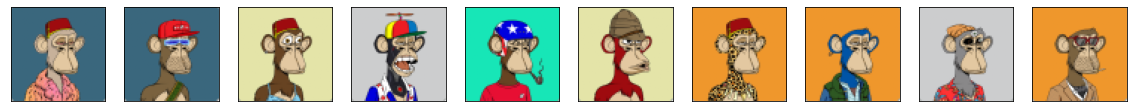

In [168]:
def plot_images(n, images):

    # number of example images to show
    plt.figure(figsize=(20, 10))
    
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
            
    plt.show()
    
plot_images(10, image_plotting)

# 2. Defining Models

## 2.1 Generator

In [169]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(4, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 4)

    return model

generator = make_generator_model()
generator.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_24 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_25 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 8, 8, 128)        

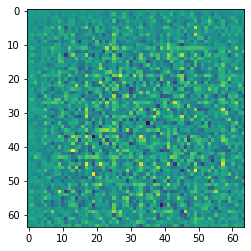

In [146]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

## 2.2 Discriminator

In [147]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 4]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [149]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00081473]], shape=(1, 1), dtype=float32)


In [150]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [151]:
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [152]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [154]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

    for image_batch in dataset:
        train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [155]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
  
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [171]:
BATCH_SIZE = 5
train(train_dataset, EPOCHS)

ValueError: in user code:

    C:\Users\Nikita\AppData\Local\Temp/ipykernel_10560/463366289.py:10 train_step  *
        real_output = discriminator(images, training=True)
    C:\Users\Nikita\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Nikita\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\input_spec.py:235 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential_8 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (64, 64, 4)
